In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path = Path('images'); path

PosixPath('images')

In [4]:
def get_labels(file_path): return float(str(file_path).split(",")[1].split(".p")[0])

In [5]:
data_percentage = (ImageList.from_folder(path)
                .split_by_folder(train = "train_percentage", valid = "validation_percentage")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

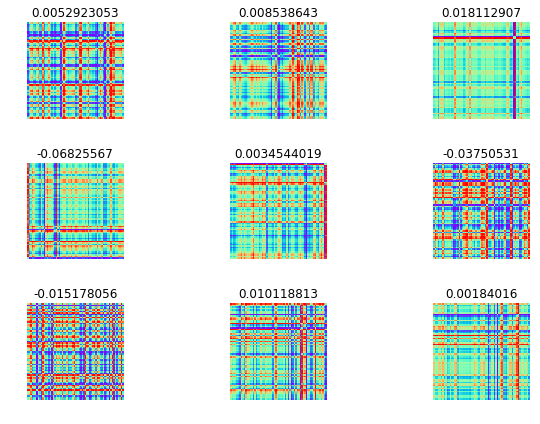

In [6]:
data_percentage.show_batch(3, figsize=(9,6))

In [7]:
learn_percentage = cnn_learner(data_percentage, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_percentage.load('percentage-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (13015 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: FloatList
-0.03093247,-0.019524118,-0.007184796,-0.01866832,-0.019109389
Path: images;

Valid: LabelList (1260 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: FloatList
-0.026998017,-0.030449305,-0.020590356,-0.0014728702,0.0075188144
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [8]:
last_layers_percentage = list(children(learn_percentage.model))[-1][-1]
learn_percentage.model[-1] = learn_percentage.model[-1][:-1]
last_layers_percentage

Linear(in_features=512, out_features=1, bias=True)

In [9]:
    data_RSI = (ImageList.from_folder(path)
                .split_by_folder(train = "train_RSI", valid = "validation_RSI")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

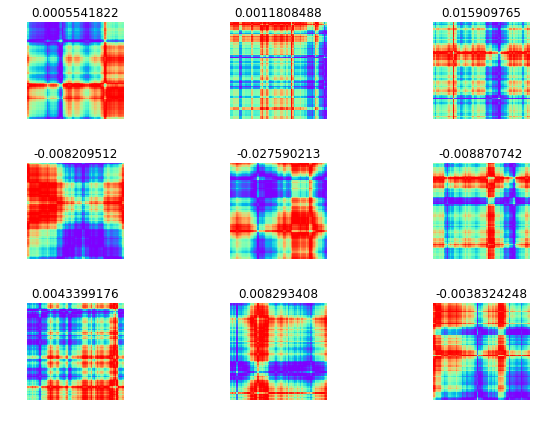

In [10]:
data_RSI.show_batch(3, figsize=(9,6))

In [11]:
learn_RSI = cnn_learner(data_RSI, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_RSI.load('RSI-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (13015 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: FloatList
-0.03093247,-0.019524118,-0.007184796,-0.01866832,-0.019109389
Path: images;

Valid: LabelList (1260 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: FloatList
-0.026998017,-0.030449305,-0.020590356,-0.0014728702,0.0075188144
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [12]:
last_layers_RSI = list(children(learn_RSI.model))[-1][-1]
learn_RSI.model[-1] = learn_RSI.model[-1][:-1]

In [13]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): 
        imgTensor1 = self.x1[i].data#.contiguous()
        imgTensor2 = self.x2[i].data#.contiguous()
        y = torch.from_numpy(self.y[i].data)
        #y =  torch.from_numpy(self.y[i].data).contiguous()
        
        return (imgTensor1, imgTensor2), y

In [14]:
train_ds = ConcatDataset(data_percentage.train_ds.x, data_RSI.train_ds.x, data_percentage.train_ds.y)
valid_ds = ConcatDataset(data_percentage.valid_ds.x, data_RSI.valid_ds.x, data_percentage.valid_ds.y)

In [15]:
bs = 64
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)
data = DataBunch(train_dl, valid_dl)

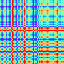

In [16]:
data.train_ds.x1[0]

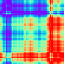

In [17]:
data.train_ds.x2[0]

In [18]:
class ConcatModel(nn.Module):
    def __init__(self, cnn_1, cnn_2, last_layers_1, last_layers_2):
        super().__init__()
        self.cnn_1 = cnn_1
        self.cnn_2 = cnn_2
        
        self.last_layers = nn.Linear(2*512, 1, True)
        self.last_layers.weight[0].data[0:512] = last_layers_1.weight[0].data
        self.last_layers.weight[0].data[512:2*512] = last_layers_2.weight[0].data
        
        
    def forward(self, x1, x2):
        x1 = self.cnn_1(x1)
        x2 = self.cnn_2(x2)
        
        x = torch.cat((x1, x2), dim=1)
        x = self.last_layers(x)
        
        return x

In [19]:
model = ConcatModel(learn_percentage.model, learn_RSI.model, last_layers_percentage, last_layers_RSI)
model

ConcatModel(
  (cnn_1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (downsample

In [20]:
layer_groups = [nn.Sequential(*flatten_model(learn_percentage.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_RSI.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_RSI.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_RSI.layer_groups[2]))] 

In [21]:
learn = Learner(data, model, metrics= [r2_score, root_mean_squared_error], layer_groups=layer_groups)

In [22]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.003584,0.000653,-0.334154,0.024191,01:37
1,0.003404,0.000945,-1.547463,0.029103,01:05
2,0.004298,0.000695,-0.474900,0.025045,01:14
3,0.003956,0.000746,-0.828872,0.025871,01:30
4,0.003399,0.000718,-0.681285,0.025552,01:43
5,0.003813,0.000661,-0.357696,0.024234,01:29
6,0.003150,0.000643,-0.317054,0.023960,01:02
7,0.002970,0.000631,-0.273304,0.023683,01:09
8,0.003291,0.000634,-0.303158,0.023799,01:04


In [23]:
learn.save('percentage+RSI-stage1')

In [22]:
learn.load('percentage+RSI-stage1')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=DataBunch;

Train: <__main__.ConcatDataset object at 0x7fd8812f1b70>;

Valid: <__main__.ConcatDataset object at 0x7fd8812f1a58>;

Test: None, model=ConcatModel(
  (cnn_1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


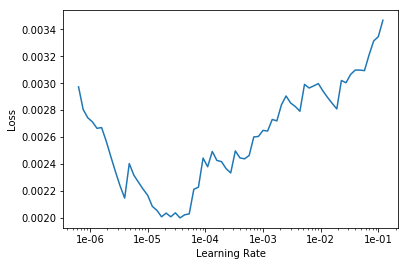

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(9, max_lr = slice(3e-6,3e-5))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.003252,0.000630,-0.279975,0.023683,01:51
1,0.003304,0.000629,-0.275726,0.023659,01:43
2,0.003137,0.000639,-0.316642,0.023884,01:15
3,0.003023,0.000623,-0.249878,0.023511,01:06
4,0.003017,0.000635,-0.291078,0.023777,01:10
5,0.003437,0.000632,-0.279702,0.023713,01:07
6,0.003016,0.000636,-0.298874,0.023805,01:32
7,0.003832,0.000635,-0.294489,0.023789,01:13
8,0.003104,0.000630,-0.277155,0.023677,01:05


In [25]:
learn.save('percentage+RSI-stage2')

In [27]:
learn.load('percentage+RSI-stage2')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=DataBunch;

Train: <__main__.ConcatDataset object at 0x7fd8812f1b70>;

Valid: <__main__.ConcatDataset object at 0x7fd8812f1a58>;

Test: None, model=ConcatModel(
  (cnn_1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bi

https://docs.fast.ai/data_block.html#Add-a-test-set

In [28]:
data_percentage_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_percentage", valid = "test_percentage")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_RSI_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_RSI", valid = "test_RSI")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

train_ds = ConcatDataset(data_percentage_test.train_ds.x, data_RSI_test.train_ds.x, data_percentage_test.train_ds.y)
test_ds = ConcatDataset(data_percentage_test.valid_ds.x, data_RSI_test.valid_ds.x, data_percentage_test.valid_ds.y)

bs = 64
train_dl = DataLoader(train_ds, bs)
test_dl = DataLoader(test_ds, bs)
data_test = DataBunch(train_dl, test_dl)

In [29]:
data_test.test_dl

In [30]:
pred_metrics = learn.validate(data_test.test_dl)

In [31]:
pred_metrics

[0.00062991865, tensor(-0.2772), tensor(0.0237)]